**Problem 2.1**

Attributions: Elena looked at sleep latency, Shashank looked at mean daytime and mean nighttime activity, and Michelle looked at the percent time spent in inactive, low activity, and high activity states. 

In [32]:
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special
import re

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

import beeswarm as bs
# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

**Sleep Latency**

One sleep behavior parameter that we are interested in from the Prober, et al. paper is "sleep latency," which the authors define as "the length of time from lights out to the start of the first rest bout." This could be taken as one measure of sleepiness (or wakefulness); presumably sleepier fish will tend to have lower sleep latency. We will define the start of a rest bout as the first in a string of one or more consecutive "rest minutes" (one-minute bins with no detectable activity for a given fish). 

First, we load the clean, tidy `DataFrame` we created for the one-minute-interval data in tutorial 2a. We will call this `df`. Note that we want the one-minute-interval data because we are looking at rest bouts, which are defined on a minute-by-minute basis. 

In [33]:
df = pd.read_csv("./data/130315_1_minute_intervals.csv", comment="#")

We choose to look at what happens on the third night (the night of "day 2" in the `DataFrame`, since the first day is "day 0"), as the fish should be acclimated to their environment by then.

In [34]:
# Get a view into the third night
df_n2 = df[(df['day']==2) & (df['light']==False)]
df_n2.head()

fish genotype  day  light   CLOCK    zeit  activity  window
3146  FISH1      het    2  False  14.011  62.011       6.6    55.7
3147  FISH1      het    2  False  14.028  62.028       8.1    58.0
3148  FISH1      het    2  False  14.044  62.044       6.7    54.5
3149  FISH1      het    2  False  14.061  62.061       3.1    49.2
3150  FISH1      het    2  False  14.078  62.078       1.4    49.3

Next, we define a function, `sleep_latency`. When given an activity series, this function will return the index of the first minute with no detectable activity. As we will apply this function to a `DataFrame` containing only the data from the third night, this index will be equivalent to the number of minutes between turning the light off and the start of the first rest bout. For example, if there is no detectable activity in the first minute after turning off the light, the index will be 0. In other words, this function returns the sleep latency for a given fish. If a fish never has a rest minute during the night, we will say that it has a sleep latency of 600 minutes (the number of minutes in the whole night). We expect that we will subsequently be able to drop these fish as outliers, but we will keep them for now.

In [35]:
def sleep_latency (s, wake_threshold):
    """
    Given activity series s, returns the index of the first minute with
    no detectable activity. 
    """
    # Get Boolean for rest
    rest = (s < wake_threshold)
    
    # Convert to NumPy array if a Pandas Series
    if type(rest) is pd.core.series.Series:
        rest = rest.values
    
    # Find the index of the first minute with no detectable activity
    if True not in rest:
        first_rest = 600
    else:
        first_rest = np.argmax(rest==True)
        
    return first_rest      

Now that we can compute sleep latency, let's look at this parameter for the third night. As in the Prober, et al. paper, we will use a wake threshold of 0. However, because we are using floating point arithmetic, we will set the threshold to be a very small value (as a proxy for 0).  

In [36]:
# Get indices for third night
inds = (~df.light) & (df.day==2)

# Group the DataFrame
df_gb = df[inds].groupby(('fish', 'genotype'))['activity']

## Compute the rest bout lengths
df_sleep_latency = df_gb.apply(sleep_latency, wake_threshold=1e-5).reset_index()
df_sleep_latency = df_sleep_latency.rename(columns={'activity':'latency'})
df_sleep_latency.head()

fish genotype  latency
0   FISH1      het        6
1  FISH10      het        8
2  FISH11      mut       14
3  FISH12      mut       15
4  FISH13      mut       14

Okay, this looks good except that our fish are out of order. Although this won't matter for the sake of plotting our data, we'd like to rename the fish so that FISH1 becomes FISH01, FISH2 becomes FISH02, etc., so that when we sort the `DataFrame` by ascending values, all of the fish will be in order.  

In [37]:
# Use a regular expression to search for numbers in the 'fish' column of the DataFrame
regex = re.compile('\d+')
fishnames = np.array(df_sleep_latency['fish'])
nums = [regex.search(i).group() for i in df_sleep_latency['fish']]

# Add a 0 in front of every single-digit number, and rename the fish accordingly
newnums = [str(i).zfill(2) for i in nums]
newnames = ['FISH' + str(i) for i in newnums]
df_sleep_latency['fish'] = pd.Series(newnames)

# Sort the DataFrame by 'fish' in ascending order
df_sleep_latency = df_sleep_latency.sort(columns='fish').reset_index()
df_sleep_latency = df_sleep_latency.drop('index', 1)
df_sleep_latency.head()

fish genotype  latency
0  FISH01      het        6
1  FISH02       wt        6
2  FISH03      het        5
3  FISH04      mut        6
4  FISH05      het        8

Now we want to look at our data graphically and make comparisons between the three genotypes. We chose to use box plots, because if there are any fish that did not have a rest bout during the night, their sleep latency (which we artificially set to 600, the total number of minutes in the night) would skew any calculations involving the mean. The median and quartiles are more robust (i.e. better at coping with outliers), and therefore more appropriate in this case. In addition to the box plots, we displayed all the data points by overlaying strip plots, since the total number of data points per genotype is not excessively large. 

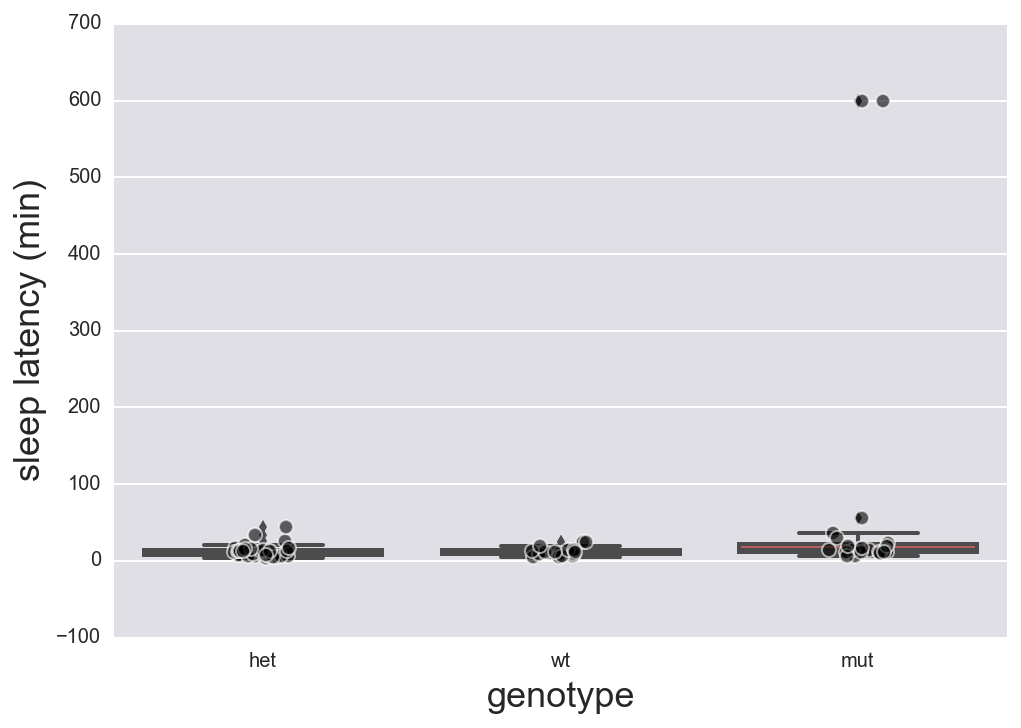

In [38]:
ax = sns.boxplot(x=df_sleep_latency['genotype'], y=df_sleep_latency['latency'])
ax  = sns.stripplot(x=df_sleep_latency['genotype'], 
                    y=df_sleep_latency['latency'], 
                    data=df_sleep_latency, 
                    jitter=True, 
                    alpha=0.6,
                    color='black')
plt.ylabel('sleep latency (min)')

We can see that there were two fish in the mutant genotype that never had a rest bout during the third night (the fish with sleep latency = 600). These fish set the scale for the y-axis, making it difficult to see what's going on with the rest of the data. Let's drop these two outliers and re-do the plot. 

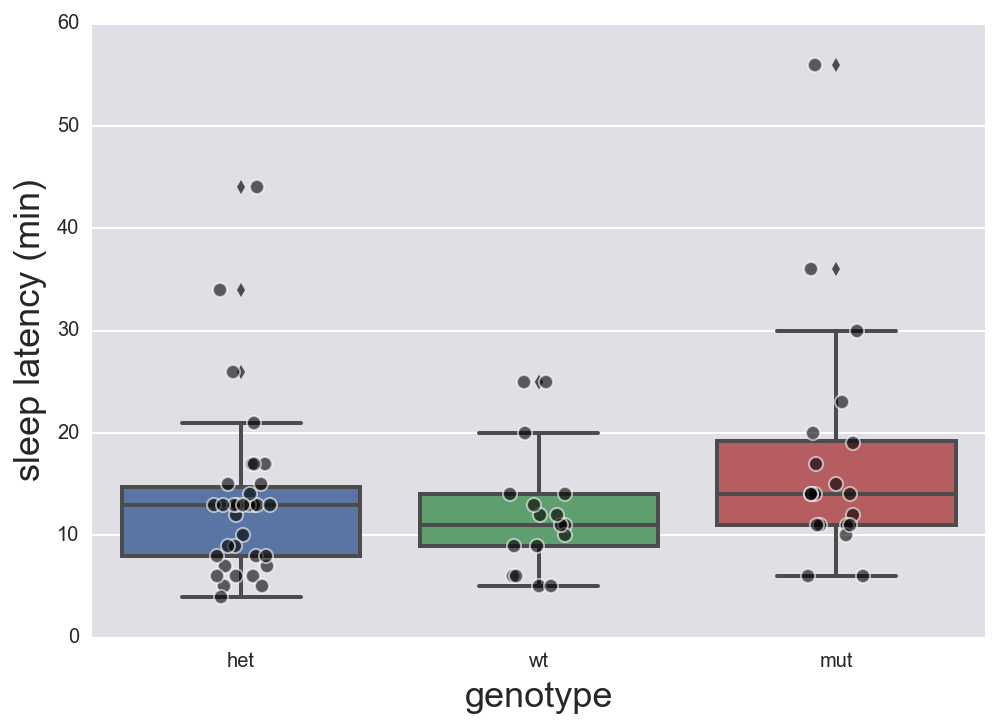

In [39]:
df_drop_outliers = df_sleep_latency[df_sleep_latency['latency'] != 600]
ax = sns.boxplot(x=df_drop_outliers['genotype'], y=df_drop_outliers['latency'])
ax  = sns.stripplot(x=df_drop_outliers['genotype'], 
                    y=df_drop_outliers['latency'], 
                    data=df_drop_outliers, 
                    jitter=True, 
                    alpha=0.6,
                    color='black')
plt.ylabel('sleep latency (min)')

Much better. 

Since we were asked to estimate the values of the parameters we are interested in, we will also directly calculate the median for each genotype. Looking at the box plots above, we can see that even in the case of the mutant, where two outliers did not rest at all, there were three fish right at the median. Therefore, we will get the same median regardless of whether we drop the two fish that didn't rest. 

In [40]:
# Calculate the median sleep latency for each genotype and return it as a new DataFrame
median_latency = df_sleep_latency.groupby('genotype')['latency'].median().reset_index()
median_latency = median_latency.rename(columns={'latency':'median sleep latency (min)'})
median_latency

genotype  median sleep latency (min)
0      het                          13
1      mut                          14
2       wt                          11

Although the median sleep latency (and overall spread) for the mutant are slightly greater than for the wildtype or heterozygous, the difference is not large enough for us to feel confident in giving a firm conclusion that the mutant tends to have a longer sleep latency. 

<u>Strengths and weaknesses of this parameter</u>

The primary strength of sleep latency as a parameter of sleep behavior is that it is a self-explanatory metric for the ability of a fish to initiate sleep at night. Deficiency in this ability is one of the criteria for insomnia (Prober et al., 2006). Sleep latency specifically measures this ability (which could plausibly be regulated differently than other aspects of sleep), unlike other metrics such as average activity throughout the night, or length or number of rest bouts. Average length of time between rest bouts could be taken as a similar measure of ability to initiate sleep, but we favor our sleep latency metric for its simplicity. 

However, sleep latency also has some weaknesses as a parameter of sleep behavior. <b>1)</b> The most obvious weakness is in the case that a fish never has a rest bout during the night. Although we chose to artificially set the maximum sleep latency as the total number of minutes in the night, we do not think this is really a satisfactory representation of never having a rest bout. Yet we could not think of a better way to quantitatively represent fish that do not have a rest bout, since we simply do not have enough information about these fish: all we can know is that their true sleep latency was somewhere between 600 minutes and infinity. Artificially setting the maximum also prevents us from using the mean as a metric, although arguably the mean would not be appropriate anyway since there are other outliers besides the fish that do not sleep at all (as shown in the box plots above). <b>2)</b> We are not familiar with to how to calculate a posterior distribution for the median, although this is a limitation of our statistical knowledge rather than a limitation of the metric itself. <b>3)</b> Sleep latency is a measure of a very specific aspect of sleep behavior, rather than general sleepiness/wakefulness. For this reason, we think that while it could be a valuable metric, it would be best to combine it with metrics for several other aspects of sleep behavior. 

**Mean daytime activity and mean nighttime activity**

Another way to parameterize sleep versus wakeful state is by calculating mean activity. In particular, we will calculate mean activity separately for daytime and nighttime. Comparing this parameter across genotypes might help us hypothesize about the function of the *aanat2* gene in zebrafish.

For this analysis, we will be looking at the mean daytime and nighttime activity during the second and fourth days. It will be interesting to see if there is any difference in the way fish behave between the two time points, as this might give some interesting insights about the function of the *aanat2* gene (beyond simply comparing the genotypes at a single time point). In order to do this, let's first calculate the mean activity of each individual fish during the daytime and nighttime on our two days of interest. We've already read in the tidy csv file and stored it as `df`, when we looked at the sleep latency parameter. Here we group this `DataFrame` by genotype as well as by fish so that later we can make comparisons across genotypes.

In [41]:
#groupby method comes in handy when extracting data from a tidy dataset.
#get mean data points for day time.
SecondDayActivity = df [(df["day"]==1) & (df["light"]==True)].groupby(("fish","genotype"))["activity"].mean().reset_index()
FourthDayActivity = df [(df["day"]==3) & (df["light"]==True)].groupby(("fish","genotype"))["activity"].mean().reset_index()

#get mean data points for night time.
SecondNightActivity = df[(df["day"]==1) & (df["light"]==False)].groupby(("fish","genotype"))["activity"].mean().reset_index()
FourthNightActivity = df[(df["day"]==3) & (df["light"]==False)].groupby(("fish","genotype"))["activity"].mean().reset_index()

Now that we have the mean data points, for the ease of this analysis, we will merge these in to a new data frame for easier comparison across genotypes.

In [42]:
#concatenate across columns.
CombinedSleepData = pd.concat([SecondDayActivity[["fish","genotype","activity"]],
                              SecondNightActivity[["activity"]],
                              FourthDayActivity[["activity"]],
                              FourthNightActivity[["activity"]]], axis=1) 

The column names are messed up. Let's fix that.

In [43]:
CombinedSleepData.columns = ["fish","genotype","MeanSecondDayActivity","MeanSecondNightActivity",
                           "MeanFourthDayActivity","MeanFourthNightActivity"]

Let's take a look at the mean daytime and nighttime activity on the second day and night, respectively compared across the three genotypes.

In [44]:
CombinedSleepData.groupby("genotype").mean().reset_index()

genotype  MeanSecondDayActivity  MeanSecondNightActivity  \
0      het               4.453268                 0.900623   
1      mut               3.882942                 2.405909   
2       wt               4.989648                 0.951853   

   MeanFourthDayActivity  MeanFourthNightActivity  
0               6.699870                 1.305324  
1               6.467198                 2.841098  
2               6.349120                 1.030118

As can be calculated from the above `DataFrame`, the mean second day activity of the mutant fish is **0.77 times** the activity of wildtype fish. However, the mutant nighttime activity is **2.5 times** the wildtype fish night time activity, which makes sense since the *aanat2* gene has been hypothesized to play an important role in melatonin production. The absence of this gene would result in low melatonin levels in mutant fish, hence increasing their night time activity. (Gandhi et. al., 2015 - Neuron) The difference in day time activities goes away on the fourth day, and the mean activity seems similar across all genotypes. However, the mutant is still **2.75 times** more active than the wildtype fish during the night. However, this could be because of many reasons, one of which is that there are potential outliers in the population. Let's plot the data and compare it across genotypes and try to identify if there are any outliers.


We'll combine data from the same day and plot it using the `beeswarm` module.

In [45]:
ListOfActsSecondDay = [ CombinedSleepData.MeanSecondDayActivity[CombinedSleepData.genotype=="wt"],
             CombinedSleepData.MeanSecondDayActivity[CombinedSleepData.genotype=="het"],
            CombinedSleepData.MeanSecondDayActivity[CombinedSleepData.genotype=="mut"] ]

ListOfActsSecondNight = [ CombinedSleepData.MeanSecondNightActivity[CombinedSleepData.genotype=="wt"],
             CombinedSleepData.MeanSecondNightActivity[CombinedSleepData.genotype=="het"],
            CombinedSleepData.MeanSecondNightActivity[CombinedSleepData.genotype=="mut"] ]

ListOfActsFourthDay = [ CombinedSleepData.MeanFourthDayActivity[CombinedSleepData.genotype=="wt"],
             CombinedSleepData.MeanFourthDayActivity[CombinedSleepData.genotype=="het"],
            CombinedSleepData.MeanFourthDayActivity[CombinedSleepData.genotype=="mut"] ]

ListOfActsFourthNight = [ CombinedSleepData.MeanFourthNightActivity[CombinedSleepData.genotype=="wt"],
             CombinedSleepData.MeanFourthNightActivity[CombinedSleepData.genotype=="het"],
            CombinedSleepData.MeanFourthNightActivity[CombinedSleepData.genotype=="mut"] ]

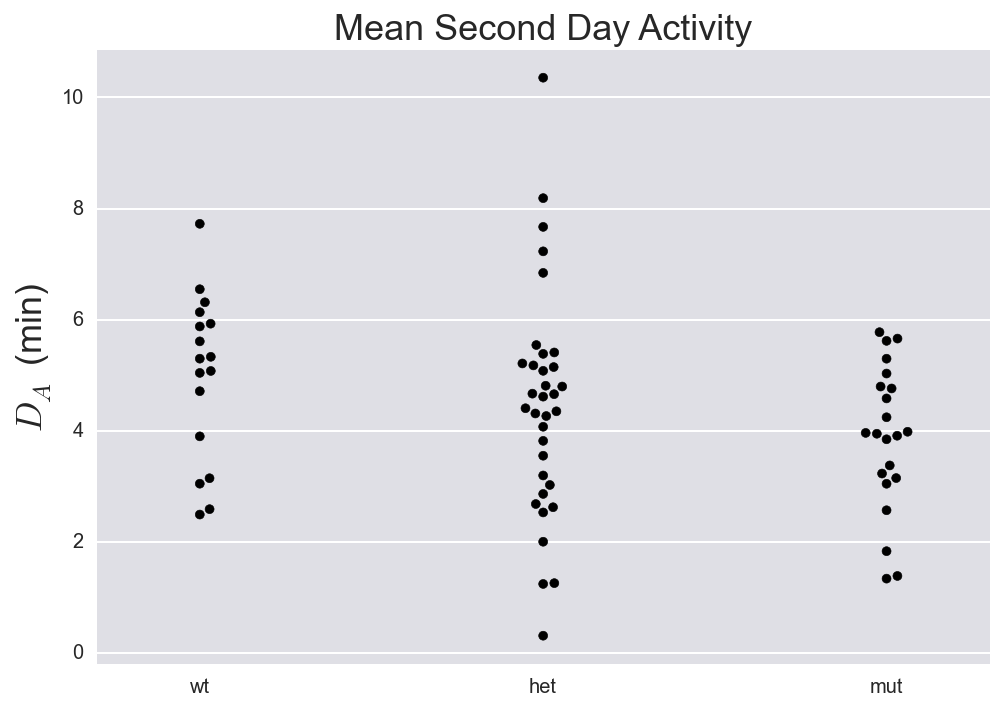

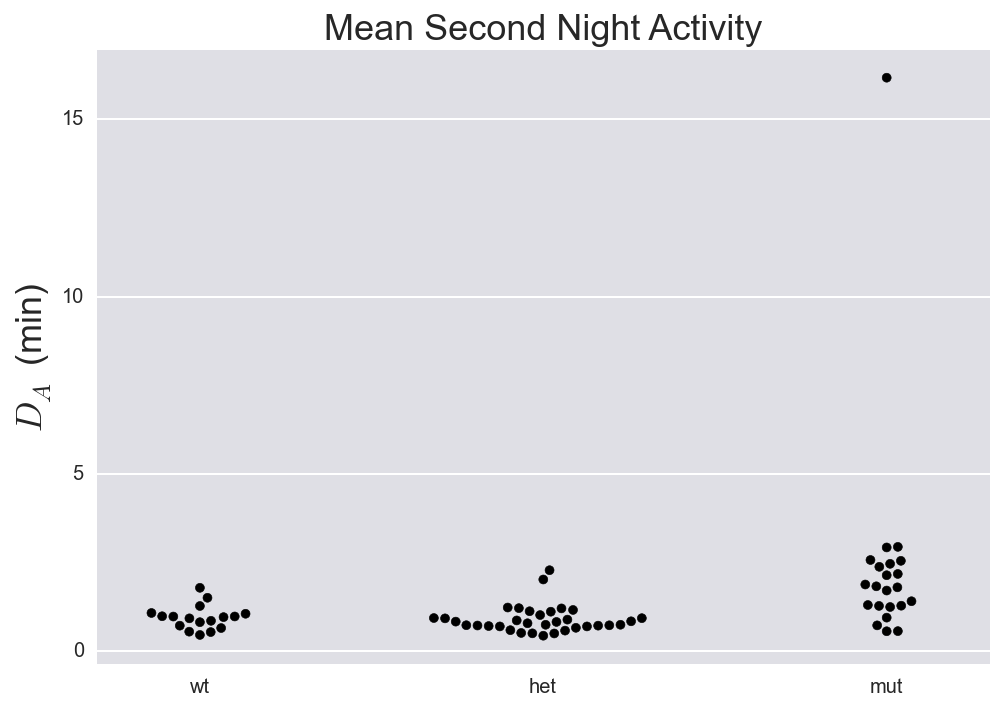

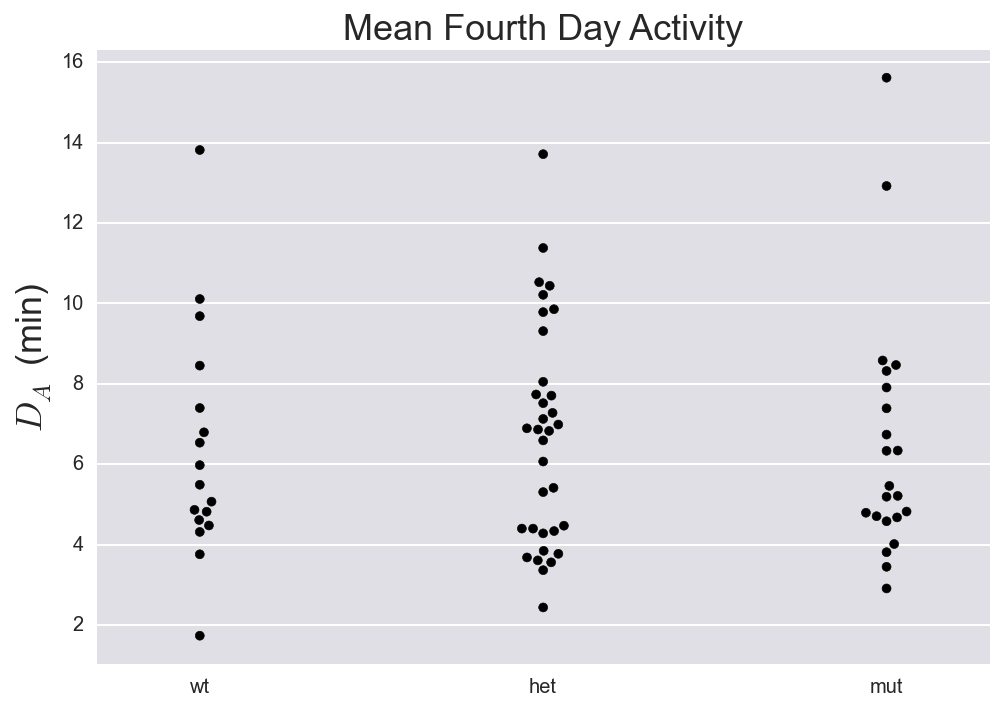

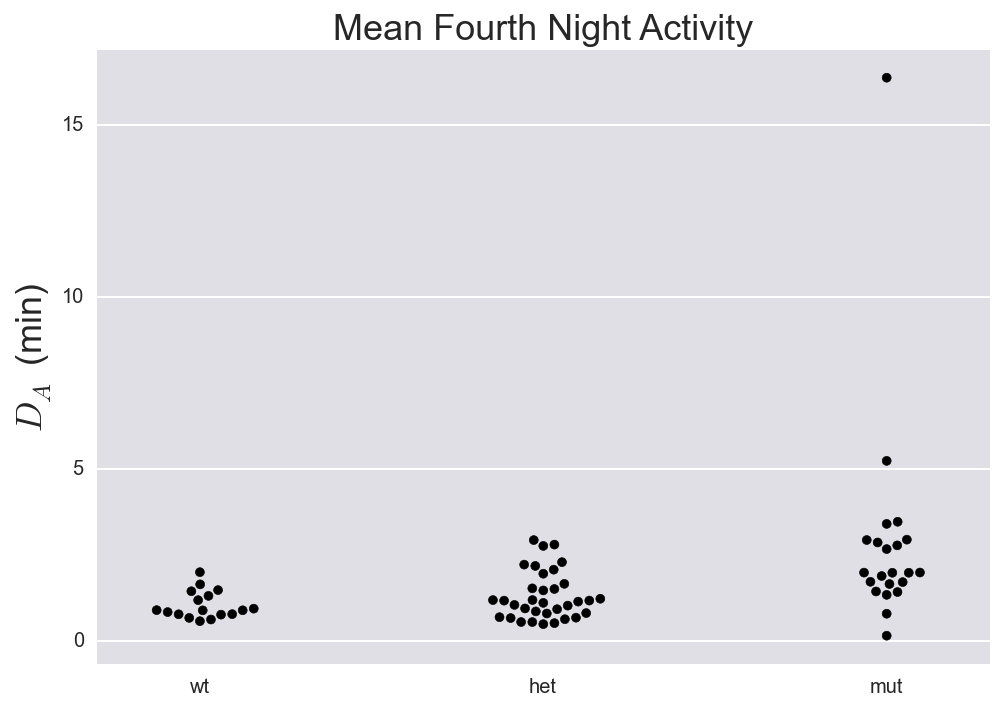

In [46]:
_= bs.beeswarm(ListOfActsSecondDay,labels = ["wt","het","mut"])
plt.ylabel("$D_A$ (min)")
plt.grid(axis="x")

plt.title("Mean Second Day Activity")

_= bs.beeswarm(ListOfActsSecondNight,labels = ["wt","het","mut"])
plt.ylabel("$D_A$ (min)")
plt.grid(axis="x")

plt.title("Mean Second Night Activity")

_= bs.beeswarm(ListOfActsFourthDay,labels = ["wt","het","mut"])
plt.ylabel("$D_A$ (min)")
plt.grid(axis="x")

plt.title("Mean Fourth Day Activity")

_= bs.beeswarm(ListOfActsFourthNight,labels = ["wt","het","mut"])
plt.grid(axis="x")

plt.title("Mean Fourth Night Activity")
plt.ylabel("$D_A$ (min)")

**Outlier Detection**

As can be seen in the plots above, there seem to be outliers in the mutant population that are skewing the plots for mean nighttime activity. Let's identify the outliers and then remove them to see how the plot looks.

In [47]:
#Identify outliers
SecondNightOutlier = SecondNightActivity[SecondNightActivity.activity==max(ListOfActsSecondNight[2])]

FourthNightOutlier = FourthNightActivity[FourthNightActivity.activity==max(ListOfActsFourthNight[2])]

Let's take a look at the outliers. 

In [48]:
SecondNightOutlier

fish genotype  activity
11  FISH21      mut    16.173

In [49]:
FourthNightOutlier

fish genotype  activity
49  FISH67      mut   16.3735

Fish21 and Fish67 seem to have very high mean activity during the second and fourth night, respectively. It seems like these fish are not sleeping at all during the night. Based on the assumption that the data points are Gaussian distributed, it is possible that these data points are real and that in fact, there is a biological reason as to why these fish do not sleep. However, if the data points are not Gaussian distributed, then these fish could just be outliers, hence skewing our estimate of the means. 
Let's remove them from the dataset and plot the mean activities again.

In [50]:
FilteredSecondDayActivity = SecondDayActivity.drop(SecondDayActivity.index[[11,49]])
FilteredSecondNightActivity = SecondNightActivity.drop(SecondDayActivity.index[[11,49]])
FilteredFourthDayActivity = FourthDayActivity.drop(SecondDayActivity.index[[11,49]])
FilteredFourthNightActivity = FourthNightActivity.drop(SecondDayActivity.index[[11,49]])

In [51]:
FilteredCombinedSleepData =pd.concat([FilteredSecondDayActivity[["fish","genotype","activity"]],
                                      FilteredSecondNightActivity[["activity"]],
                                      FilteredFourthDayActivity[["activity"]],
                                      FilteredFourthNightActivity[["activity"]]], axis=1)

In [52]:
FilteredCombinedSleepData.columns=["fish","genotype","MeanSecondDayActivity","MeanSecondNightActivity",
                           "MeanFourthDayActivity","MeanFourthNightActivity"]

Now that we have removed the outliers, let's see if they had any noticable effect on the means.

In [53]:
FilteredCombinedSleepData.groupby("genotype").mean().reset_index()

genotype  MeanSecondDayActivity  MeanSecondNightActivity  \
0      het               4.453268                 0.900623   
1      mut               4.042318                 1.809383   
2       wt               4.989648                 0.951853   

   MeanFourthDayActivity  MeanFourthNightActivity  
0               6.699870                 1.305324  
1               5.909635                 2.299508  
2               6.349120                 1.030118

Once we remove the outliers, we can see that the mutant fish is still marginally less active than the wildtype and the heterozygous population (**0.81 times** the wildtype activity during the second day, and **0.93 times** the wildtype activity during the fourth day.) During the night, however, the mutant fish is still more active when compared to the wildtype population (**1.9 times** the wildtype activity during the second night, and **2.23 times** the wildtype activity during the fourth night.) It does seem pretty obvious that the gene knockout is having a sleep deprivation effect on the fish.

In [54]:
FilteredListOfActsSecondDay = [ FilteredCombinedSleepData.MeanSecondDayActivity[FilteredCombinedSleepData.genotype=="wt"],
             FilteredCombinedSleepData.MeanSecondDayActivity[FilteredCombinedSleepData.genotype=="het"],
            FilteredCombinedSleepData.MeanSecondDayActivity[FilteredCombinedSleepData.genotype=="mut"] ]

FilteredListOfActsSecondNight = [ FilteredCombinedSleepData.MeanSecondNightActivity[FilteredCombinedSleepData.genotype=="wt"],
             FilteredCombinedSleepData.MeanSecondNightActivity[FilteredCombinedSleepData.genotype=="het"],
            FilteredCombinedSleepData.MeanSecondNightActivity[FilteredCombinedSleepData.genotype=="mut"] ]

FilteredListOfActsFourthDay = [ FilteredCombinedSleepData.MeanFourthDayActivity[FilteredCombinedSleepData.genotype=="wt"],
             FilteredCombinedSleepData.MeanFourthDayActivity[FilteredCombinedSleepData.genotype=="het"],
            FilteredCombinedSleepData.MeanFourthDayActivity[FilteredCombinedSleepData.genotype=="mut"] ]

FilteredListOfActsFourthNight = [ FilteredCombinedSleepData.MeanFourthNightActivity[FilteredCombinedSleepData.genotype=="wt"],
             FilteredCombinedSleepData.MeanFourthNightActivity[FilteredCombinedSleepData.genotype=="het"],
            FilteredCombinedSleepData.MeanFourthNightActivity[FilteredCombinedSleepData.genotype=="mut"] ]

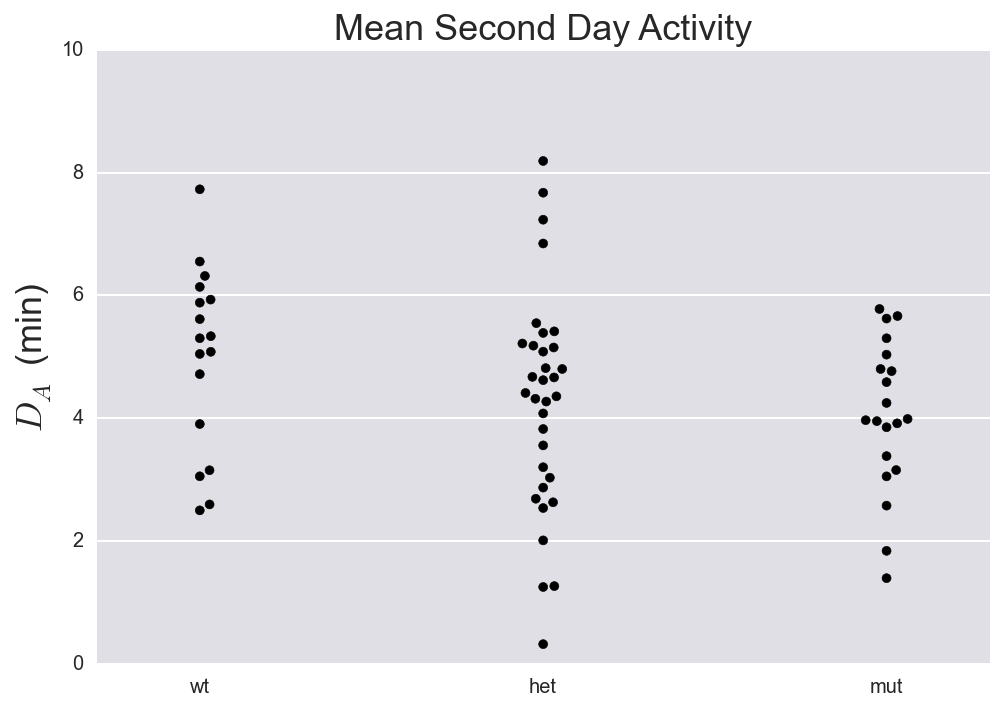

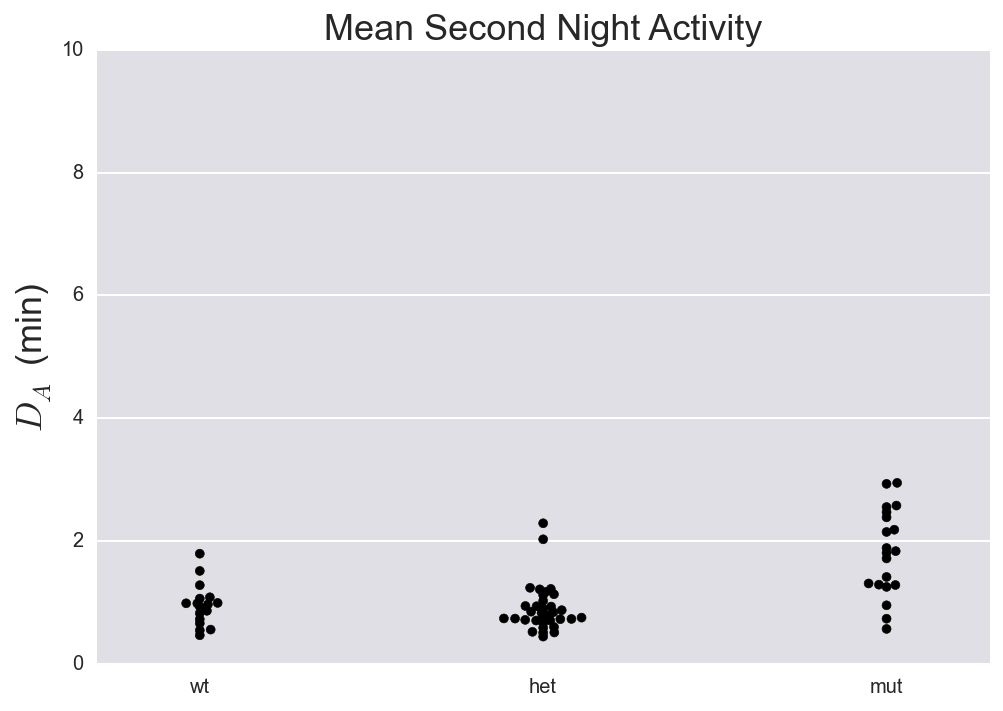

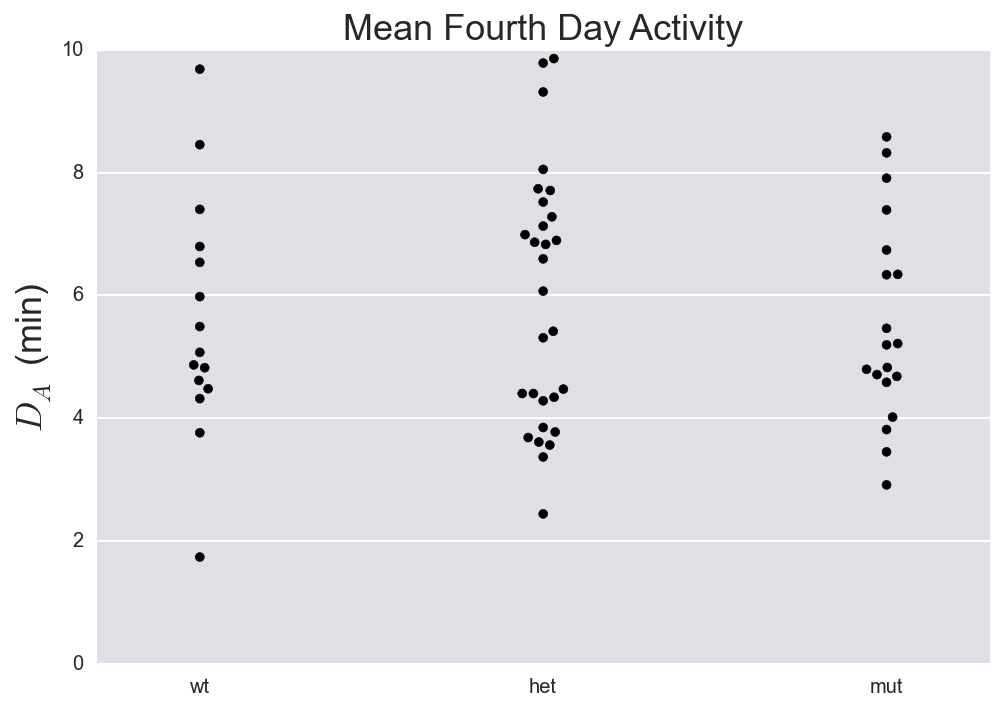

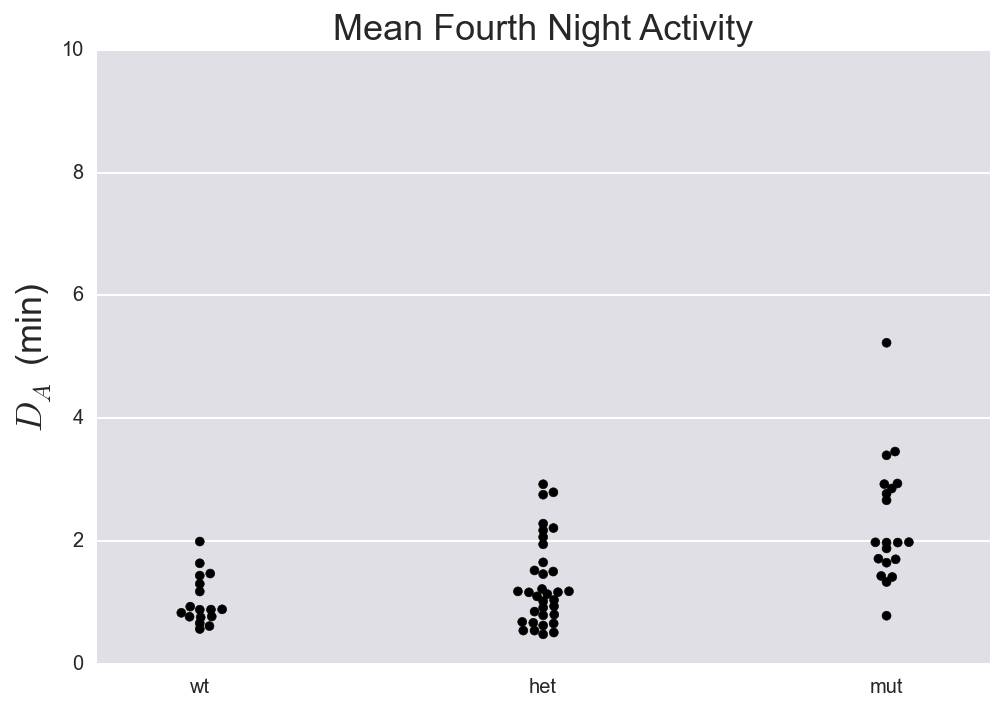

In [55]:
_= bs.beeswarm(FilteredListOfActsSecondDay,labels = ["wt","het","mut"])
plt.ylabel("$D_A$ (min)")
plt.grid(axis="x")
plt.ylim(0,10)
plt.title("Mean Second Day Activity")

_= bs.beeswarm(FilteredListOfActsSecondNight,labels = ["wt","het","mut"])
plt.ylabel("$D_A$ (min)")
plt.grid(axis="x")
plt.ylim(0,10)
plt.title("Mean Second Night Activity")

_= bs.beeswarm(FilteredListOfActsFourthDay,labels = ["wt","het","mut"])
plt.ylabel("$D_A$ (min)")
plt.grid(axis="x")
plt.ylim(0,10)
plt.title("Mean Fourth Day Activity")

_= bs.beeswarm(FilteredListOfActsFourthNight,labels = ["wt","het","mut"])
plt.grid(axis="x")
plt.title("Mean Fourth Night Activity")
plt.ylim(0,10)
plt.ylabel("$D_A$ (min)")

Now that the outliers have been removed (and the y-axis assigned uniformly across the four time points,) we will estimate the means using the student t-distribution, which allows us to calculate the best estimate for the average activity time spent by the fish in the four time points without any information about the standard deviation.
In order to do that, we will use the function that was defined by Justin during the tutorial.

In [56]:
def student_t(mu, x):
    """
    Returns the Student-t distribution for values of mu with data x.
    We could use scipy.stats for this, but we'll do it ourselves.
    """
    # Number of data
    n = len(x)
    
    # Mean of data
    x_mean = x.mean()
    
    # Compute r^2
    r2 = ((x - x_mean)**2).sum() / n
    
    # Compute the mu-dependent part
    t = (1.0 + (mu - x_mean)**2 / r2)**(-n / 2.0)
    
    # Normalize and return
    return -scipy.special.beta(-0.5, n / 2.0) / 2.0 / np.pi / np.sqrt(r2) * t

Let's plot the mean estimates for the second day. These estimates have been calculated on the Filtered dataset, the one from which the two outliers were removed. Based on the distribution of the data points in the fish population, it would be possible to find other potential outliers. However, for the simplicity of this analysis, we will assume that there were only two outliers in the population.

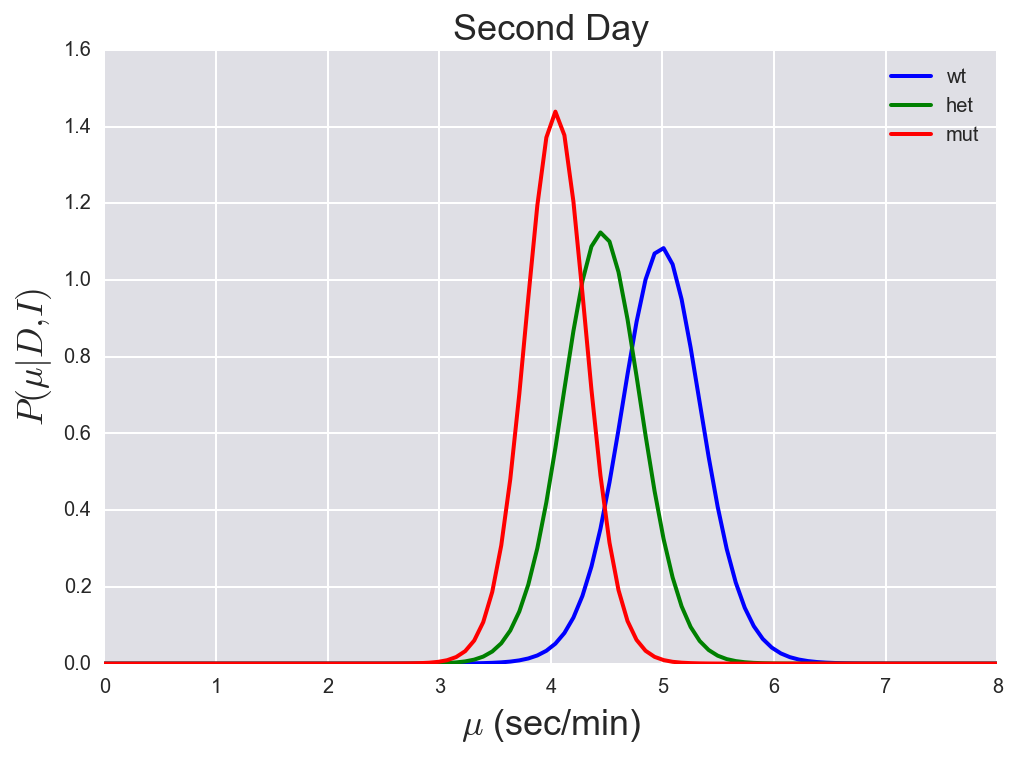

In [57]:
mu = np.linspace(0.0, 8.0,100)

post_wt= student_t(mu,FilteredCombinedSleepData.MeanSecondDayActivity[FilteredCombinedSleepData.genotype=="wt"])
post_het= student_t(mu,FilteredCombinedSleepData.MeanSecondDayActivity[FilteredCombinedSleepData.genotype=="het"])
post_mut= student_t(mu,FilteredCombinedSleepData.MeanSecondDayActivity[FilteredCombinedSleepData.genotype=="mut"])

plt.plot(mu, post_wt,color="blue")
plt.plot(mu, post_het,color="green")
plt.plot(mu, post_mut,color="red")
plt.xlabel(r'$\mu$ (sec/min)')
plt.ylabel(r'$P(\mu|D,I)$')
plt.title("Second Day")
lg = plt.legend(('wt', 'het', 'mut'), loc='upper right')

There doesn't seem to be much of a difference between the mean activity time of the wildtype population when compared with the mutant and heterozygous fish population. There is a clear overlap between the three probability distributions, and we dont have enough resolution in the data set to make any significant conclusions.

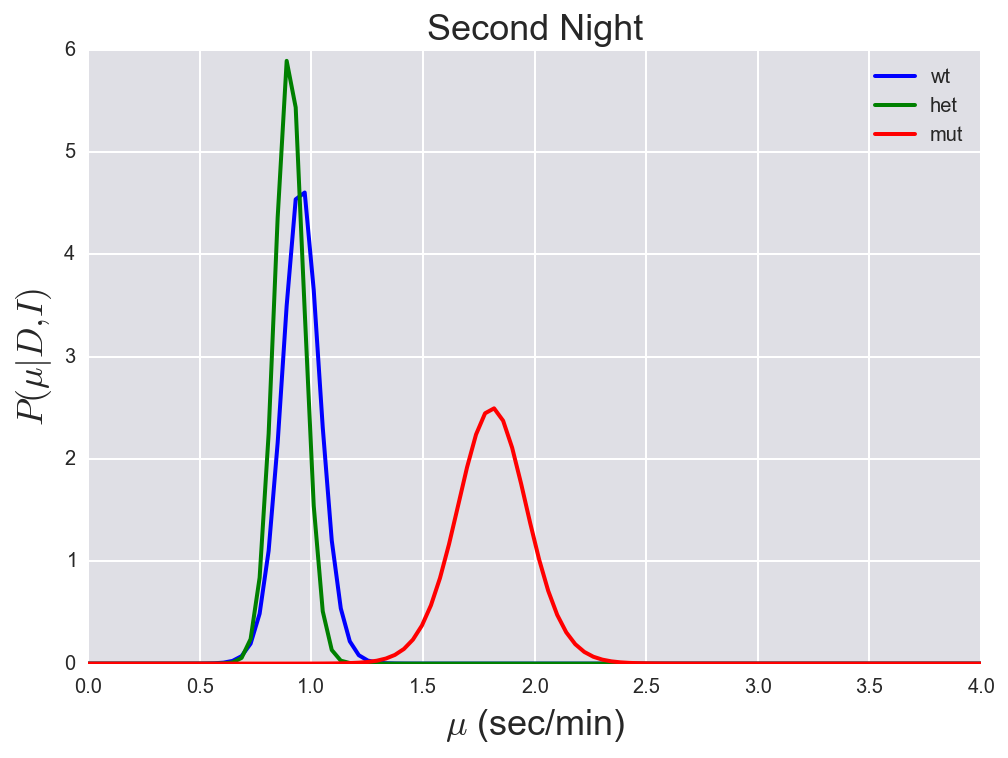

In [58]:
mu = np.linspace(0.0, 4.0,100)

post_wt= student_t(mu,FilteredCombinedSleepData.MeanSecondNightActivity[FilteredCombinedSleepData.genotype=="wt"])
post_het= student_t(mu,FilteredCombinedSleepData.MeanSecondNightActivity[FilteredCombinedSleepData.genotype=="het"])
post_mut= student_t(mu,FilteredCombinedSleepData.MeanSecondNightActivity[FilteredCombinedSleepData.genotype=="mut"])

plt.plot(mu, post_wt,color="blue")
plt.plot(mu, post_het,color="green")
plt.plot(mu, post_mut,color="red")
plt.xlabel(r'$\mu$ (sec/min)')
plt.ylabel(r'$P(\mu|D,I)$')
plt.title("Second Night")
lg = plt.legend(('wt', 'het', 'mut'), loc='upper right')

Now this is interesting. We have a well defined distribution for the mutant fish, and clearly it seems like the average activity during the night time for the mutant fish is higher than the other two populations. As far as adapting to the new environment is concerned, this sleep deprivation effect is probably due to the lack of melatonin production as a result of the *aanat2* knockout, since the other two populations of fish seem acclimated to the new environment.

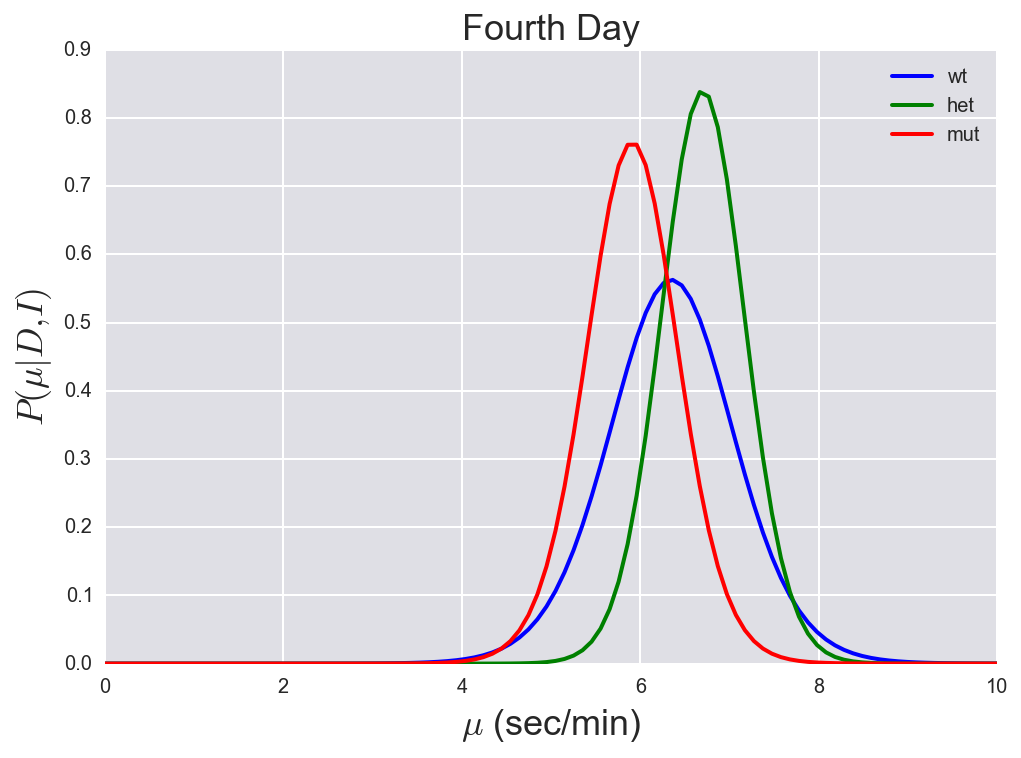

In [59]:
mu = np.linspace(0.0, 10.0,100)

post_wt= student_t(mu,FilteredCombinedSleepData.MeanFourthDayActivity[FilteredCombinedSleepData.genotype=="wt"])
post_het= student_t(mu,FilteredCombinedSleepData.MeanFourthDayActivity[FilteredCombinedSleepData.genotype=="het"])
post_mut= student_t(mu,FilteredCombinedSleepData.MeanFourthDayActivity[FilteredCombinedSleepData.genotype=="mut"])

plt.plot(mu, post_wt,color="blue")
plt.plot(mu, post_het,color="green")
plt.plot(mu, post_mut,color="red")
plt.xlabel(r'$\mu$ (sec/min)')
plt.ylabel(r'$P(\mu|D,I)$')
plt.title("Fourth Day")
lg = plt.legend(('wt', 'het', 'mut'), loc='upper right')

Just like the second day, there isn't much to infer from this distribution plot, since nothing obvious is happening to any of the fish populations.

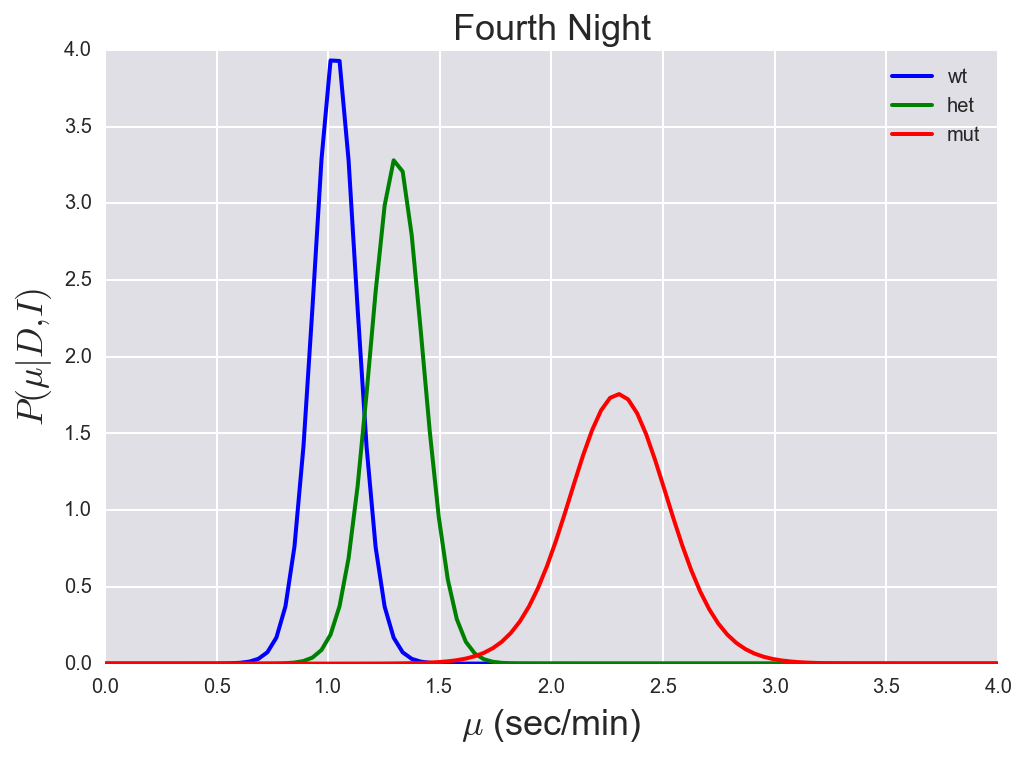

In [60]:
mu = np.linspace(0.0, 4.0,100)

post_wt= student_t(mu,FilteredCombinedSleepData.MeanFourthNightActivity[FilteredCombinedSleepData.genotype=="wt"])
post_het= student_t(mu,FilteredCombinedSleepData.MeanFourthNightActivity[FilteredCombinedSleepData.genotype=="het"])
post_mut= student_t(mu,FilteredCombinedSleepData.MeanFourthNightActivity[FilteredCombinedSleepData.genotype=="mut"])
plt.plot(mu, post_wt,color="blue")
plt.plot(mu, post_het,color="green")
plt.plot(mu, post_mut,color="red")
plt.xlabel(r'$\mu$ (sec/min)')
plt.ylabel(r'$P(\mu|D,I)$')
plt.title("Fourth Night")
lg = plt.legend(('wt', 'het', 'mut'), loc='upper right')

Other than the fact that there is a bigger difference between the activity of the mutant and wildtype populations during the fourth night as compared to the fourth day (just as we saw on the second day), an interesting aspect to look at would be whether/how well the mutant fish have adapted to the gene knockout compared to the second day/night. The reason why this would be interesting is that if the effect of losing this gene decreases over time, that would mean that the mutant fish will reach sleep activity levels close to that of the wildtype or the heterozygous population, hinting towards a mechanism by which fish would counteract low melatonin levels in order to ensure that they are not sleep deprived in the absence of this gene. 

In order to address this hypothesis, let's plot the two probability distributions (Second Day vs Fourth day and Second Night vs Fourth Night) on the same graph.

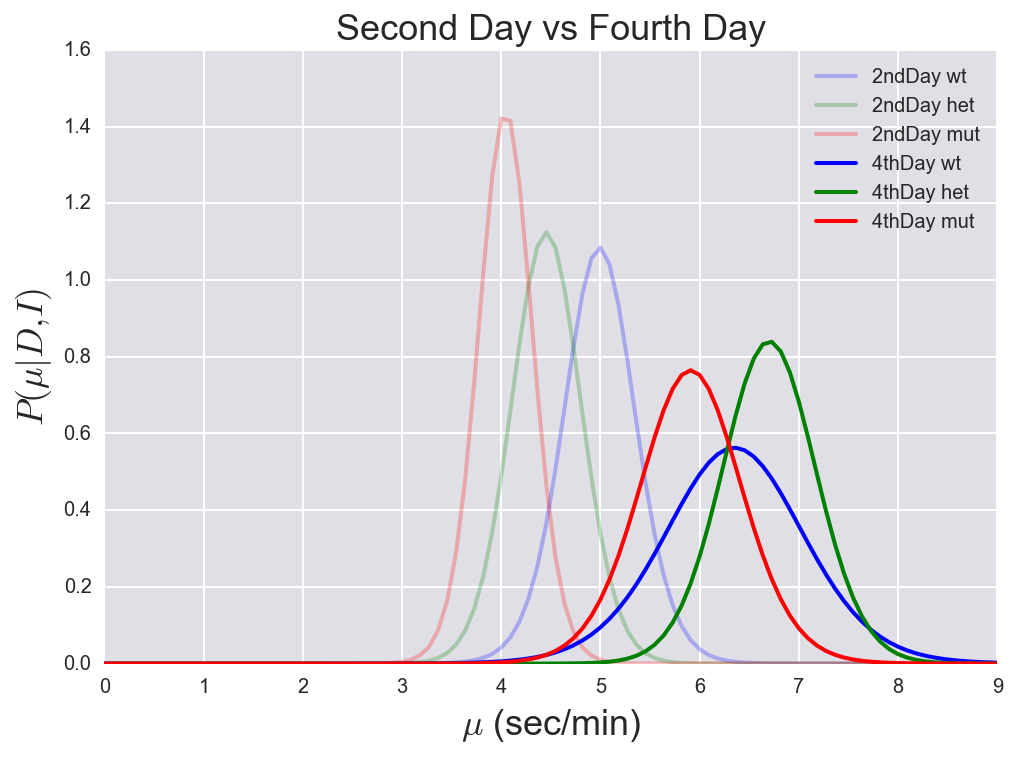

In [61]:
mu = np.linspace(0.0, 9.0,100)

SecondDayPostWT= student_t(mu,FilteredCombinedSleepData.MeanSecondDayActivity[FilteredCombinedSleepData.genotype=="wt"])
SecondDayPostHET= student_t(mu,FilteredCombinedSleepData.MeanSecondDayActivity[FilteredCombinedSleepData.genotype=="het"])
SecondDayPostMUT= student_t(mu,FilteredCombinedSleepData.MeanSecondDayActivity[FilteredCombinedSleepData.genotype=="mut"])

FourthDayPostWT= student_t(mu,FilteredCombinedSleepData.MeanFourthDayActivity[FilteredCombinedSleepData.genotype=="wt"])
FourthDayPostHET= student_t(mu,FilteredCombinedSleepData.MeanFourthDayActivity[FilteredCombinedSleepData.genotype=="het"])
FourthDayPostMUT= student_t(mu,FilteredCombinedSleepData.MeanFourthDayActivity[FilteredCombinedSleepData.genotype=="mut"])


plt.plot(mu, SecondDayPostWT, lw=2, color="blue",alpha=0.25)
plt.plot(mu, SecondDayPostHET,lw=2,color="green",alpha=0.25)
plt.plot(mu, SecondDayPostMUT,lw=2,color="red",alpha=0.25)
plt.plot(mu, FourthDayPostWT,lw=2,color="blue")
plt.plot(mu, FourthDayPostHET,lw=2,color="green")
plt.plot(mu, FourthDayPostMUT,lw=2,color="red")

plt.xlabel(r'$\mu$ (sec/min)')
plt.ylabel(r'$P(\mu|D,I)$')
plt.title("Second Day vs Fourth Day")

lg = plt.legend(('2ndDay wt', '2ndDay het', '2ndDay mut','4thDay wt', '4thDay het', '4thDay mut'), loc='upper right')


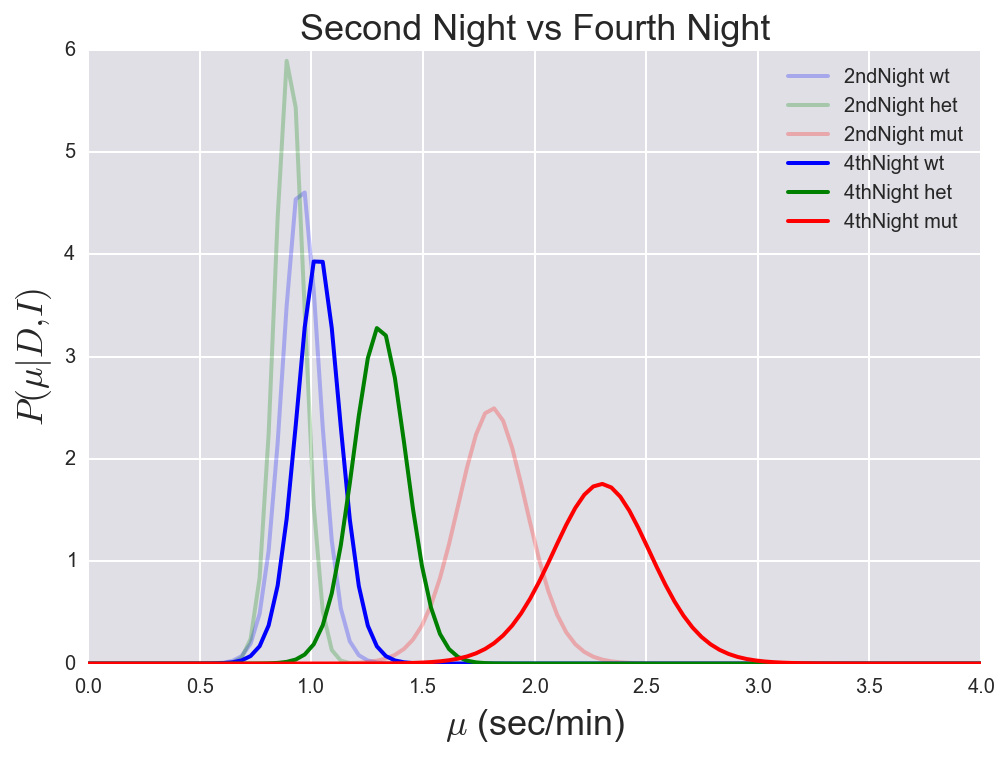

In [62]:
mu = np.linspace(0.0, 4.0,100)

SecondNightPostWT= student_t(
                    mu,FilteredCombinedSleepData.MeanSecondNightActivity[FilteredCombinedSleepData.genotype=="wt"])
SecondNightPostHET= student_t(
                    mu,FilteredCombinedSleepData.MeanSecondNightActivity[FilteredCombinedSleepData.genotype=="het"])
SecondNightPostMUT= student_t(
                    mu,FilteredCombinedSleepData.MeanSecondNightActivity[FilteredCombinedSleepData.genotype=="mut"])

FourthNightPostWT= student_t(mu,
                             FilteredCombinedSleepData.MeanFourthNightActivity[FilteredCombinedSleepData.genotype=="wt"])
FourthNightPostHET= student_t(mu,
                              FilteredCombinedSleepData.MeanFourthNightActivity[FilteredCombinedSleepData.genotype=="het"])
FourthNightPostMUT= student_t(mu,
                              FilteredCombinedSleepData.MeanFourthNightActivity[FilteredCombinedSleepData.genotype=="mut"])


plt.plot(mu, SecondNightPostWT, lw=2, color="blue",alpha=0.25)
plt.plot(mu, SecondNightPostHET,lw=2,color="green",alpha=0.25)
plt.plot(mu, SecondNightPostMUT,lw=2,color="red",alpha=0.25)
plt.plot(mu, FourthNightPostWT,lw=2,color="blue")
plt.plot(mu, FourthNightPostHET,lw=2,color="green")
plt.plot(mu, FourthNightPostMUT,lw=2,color="red")

plt.xlabel(r'$\mu$ (sec/min)')
plt.ylabel(r'$P(\mu|D,I)$')
plt.title("Second Night vs Fourth Night")

lg = plt.legend(('2ndNight wt', '2ndNight het', 
                 '2ndNight mut','4thNight wt', 
                 '4thNight het', '4thNight mut'), loc='upper right')

Lets discuss the two graphs individually:

0. **Second Day vs Fourth Day:**
As can be seen in the first graph, the mutant fish was less active during the second day when compared to the wildtype. The reason why this is interesting is that according to the literature, in vertebrates with a circadian clock, melatonin production does not begin until it is dark, which means that even though *aanat2* has been knocked out, it shouldn't have any effect on day time activity of the mutant fish. However, the fact that the activity is slightly lower than the wildtype population makes us wonder if *aanat2* has another function early on during development, which goes away later on (the mutant fish seem to catch up to the wildtype by the fourth day). In other words, the decrease in activity on the second day when compared to the wildtype fish could be due to a developmental defect that was caused as a result of *aanat2* knockout. This hypothesis is irrespective of the fact that all genotypes shift towards higher activity on the fourth day, which likely reflects the adaptation of the fish to their environment over time. 

1. **Second Night vs Fourth Night:**
In the second graph, the mutant fish seem to be more active during the fourth night when compared to their activity from the second night. The same can be observed for the heterozygous population, however, there isn't much of a difference in the mean activity of the wild type population between the second and fourth night. A possible explanation for this observation can be that two functional copies of the *aanat2* gene are required to ensure low activity during the night (what we call "sleep" state). This might help us explain why the heterozygous population exhibits an intermediate phenotype with increase in mean nighttime activity between the second and fourth night.

<u>Strengths and weaknesses of this parameter</u>
1. If the data is Gaussian distributed, the mean activity can be representative of the entire population, with "outliers" (no longer outliers but valid data points) contributing to the trend observed across genotypes. However, if the variance in the data is high, then we lose that advantage.
2. Using the methods described above, it will be very hard to identify outliers, which could skew our estimate of means.

**Percent time spent in inactive, low activity, and high activity states**

Another way to parameterize sleeping versus wakeful states is to compare the percentages of time the zebrafish spends in inactive, low activity, and high activity states. There are multiple ways we can compare these percentages. For example, we can compare these percentages across genotypes, across fish, and between daytime and nighttime. 

As a reminder, at the beginning of this notebook we already read in the tidy csv file with the one-minute-interval data and stored it as `df`. Here, we group this `DataFrame` by genotype because we are first going to compare the percentage time the fish spend in each state based on their genotype. We would expect the mutant fish to have spend a smaller percent of their time in the inactive state than the wild type fish since they cannot produce melatonin, a hormone that is associated with sleep. We expect to see the mutant fish to spend more time in both the high activity and low activity states than the wildtype.

Note that we could have grouped the `DataFrame` by fish as well as by genotype, thus calculating the percentage of time that each fish spends in each state. However, we chose to pool the data from all fish within each genotype because this enables a cleaner, more efficient graphical representation of the data later on when we make plots. (Further explanation below, before the first plots.) 

In [63]:
df_grouped = df.groupby('genotype')

Defining the inactive state as zero seconds of activity in a one minute period is obvious: no movement means inactive, movement means active. Defining the low activity and high activity states is not as obvious. The paper defines low activity as less than 1 second of activity in a one minute interval and high activity as 1 second or more of activity in a one minute interval. We argue that 1 second is too short. We don't consider a fish that is active for one 60th of our time bin to be highly active. We defined low activity as less than 2 seconds of activity in a one minute interval and high activity as 2 seconds or more of activity in a one minute interval; we consider the fish to be highly active if it is active more than one 30th of our time bin.

In [64]:
inactive = df[df['activity'] == 0]
low_activity = df[df['activity'] <= 2]
high_activity = df[df['activity'] > 2]

Now we group the `DataFrame` of each state by genotype.

In [65]:
inactive = inactive.groupby('genotype')

low_activity = low_activity.groupby('genotype')

high_activity = high_activity.groupby('genotype')

To find out the percentage of time spent in each state we must count the number of intervals spent in each state and count the total number of intervals and then divide the first by the latter.

In [66]:
# Calculating the total number of intervals in the experiment
intervals = df_grouped['activity'].count()

# Tally of number of intervals in each state
inactive_int = inactive['activity'].count()
low_activity_int = low_activity['activity'].count()
high_activty_int = high_activity['activity'].count()

# Calculate percentages
inactive_per = inactive_int/intervals
low_activity_per = low_activity_int/intervals
high_activity_per = high_activty_int/intervals

# To see these values we will print the percentages
print(inactive_per)
print(low_activity_per)
print(high_activity_per)

genotype
het    0.248500
mut    0.189506
wt     0.248906
Name: activity, dtype: float64
genotype
het    0.539930
mut    0.470005
wt     0.516480
Name: activity, dtype: float64
genotype
het    0.460070
mut    0.529995
wt     0.483520
Name: activity, dtype: float64


Now we can plot our percentages. We chose a bar graph. If we had calculated the percentages of time that each fish spends in each state, we could have used box plots or beeswarm plots. However, we preferred the bar graph representation of our pooled data. We felt that the bar graph is best because we can easily show all states with all genotypes on one plot; we can't do this as easily on a beeswarm plot (e.g., we could show all three genotypes, but we feel that doing so for more than one state per plot would start to look cluttered and difficult to understand at first glance). In our opinion, the conciseness of a bar graph outweighs the trade-off that pooling of the data obcures information about the variability within each genotype. 

To make the plots, we take the 'wt', 'het', and 'mut' percentages we calculated separately for each state and put them together in a list of values.

In [67]:
wt_per = [inactive_per.wt, low_activity_per.wt, high_activity_per.wt]
het_per = [inactive_per.het, low_activity_per.het, high_activity_per.het]
mut_per = [inactive_per.mut, low_activity_per.mut, high_activity_per.mut]

We can now plot our percentages.

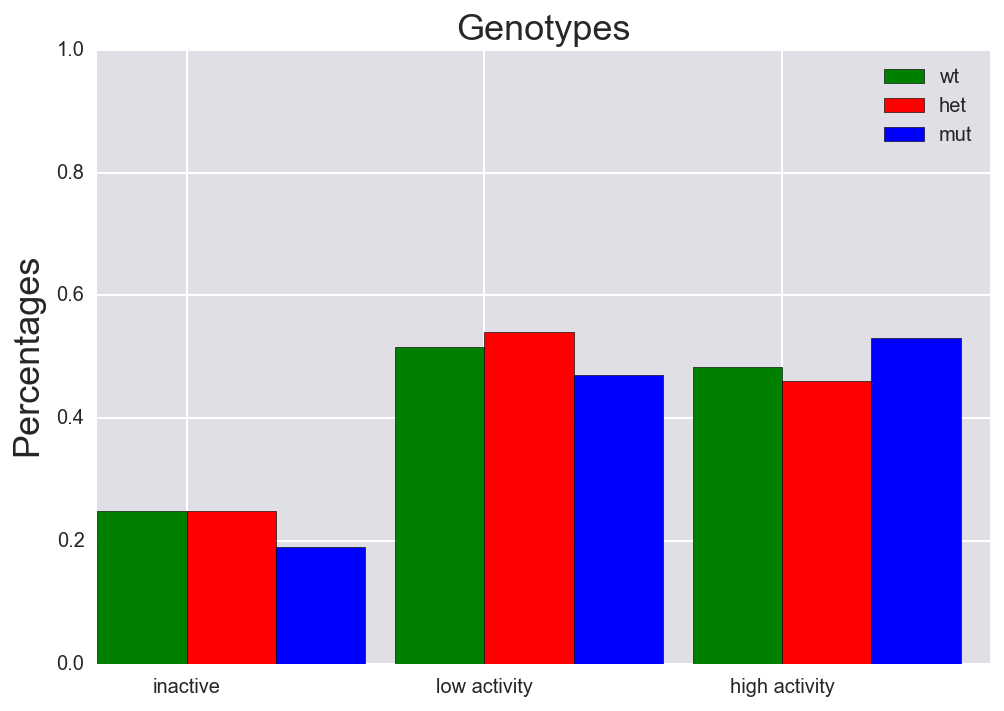

In [68]:
fig = plt.figure()
ax = plt.subplot(111)
x = np.arange(3)
wt = ax.bar(x, wt_per, width = 0.30, color='Green')
het = ax.bar(x + 0.30, het_per, width = 0.30, color='red')
mut = ax.bar(x + 0.60, mut_per, width = 0.30, color='blue')

ax.set_ylim(0,1)
ax.set_ylabel('Percentages')
ax.set_xticks(x+0.3)
ax.set_xticklabels(['inactive', 'low activity', 'high activity'])
plt.title ('Genotypes')
plt.legend(('wt', 'het', 'mut'), loc='upper right')

From the bar graph we can see that our prediction that the mutant fish would have a smaller inactive percentage than the wild type is true, but by only four percent. Overall, the genotypes spend a similar percentage of time in each state, and it is hard to make firm conclusions without further statistical analysis.

While comparing the percent of the time the fish spend in each state by genotype gives us some insight on the effects of melatonin on activity and sleep behavior, it doesn't tell us much about how light and dark affect activity. (Let us pretend that we have no prior knowledge of whether zebrafish are diurnal or nocturnal.)

We can use our parameters to compare the total percentage of time spent in each state and compare it across days and nights. We can do this for each fish individually. As an example, we will calculate the percentage a particular fish, in this case FISH1, spends in each state during the day and night.

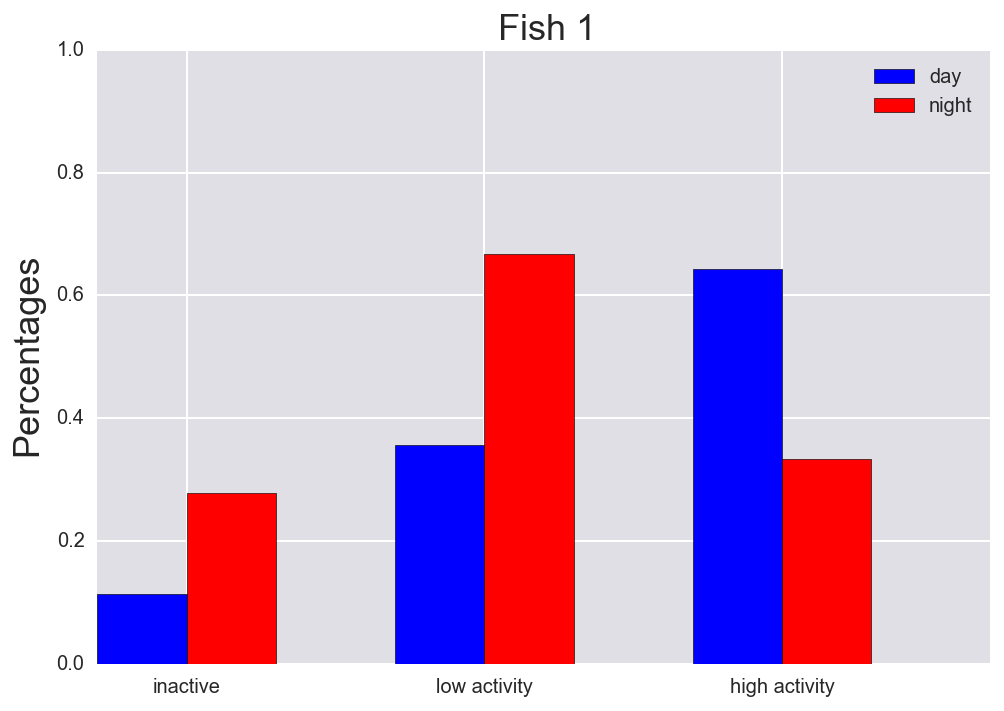

In [69]:
# Now we want to look at them per fish and compare day with night
# First we'll create a pie chart for the day and night time
df_day = df[df['light'] == True].groupby('fish')
df_night = df[df['light'] == False].groupby('fish')

# Now we want to identify the times a fish has zero activity in a one minute interval
inactive_day = df[(df['activity'] == 0) & (df['light'] == True)]
inactive_night = df[(df['activity'] == 0) & (df['light'] == False)]

# Now we want to idenitfy the times a fish has low activity
low_activity_day = df[(df['activity'] <= 2) & (df['light'] == True)]
low_activity_night = df[(df['activity'] <= 2) & (df['light'] == False)]

# Now we want to idenitfy the time a fish has high activity
high_activity_day = df[(df['activity'] > 2) & (df['light'] == True)]
high_activity_night = df[(df['activity'] > 2) & (df['light'] == False)]

# We want to group these state DataFrames by fish so we use groupby
df_inactive_day = inactive_day.groupby('fish')
df_low_activity_day = low_activity_day.groupby('fish')
df_high_activity_day = high_activity_day.groupby('fish')

df_inactive_night = inactive_night.groupby('fish')
df_low_activity_night = low_activity_night.groupby('fish')
df_high_activity_night = high_activity_night.groupby('fish')

# To find the percentage of time spent in each state we divide the number of intervals
# spent in each state by the total number of intervals during the day and night respectivitly
inactive_per_day = df_inactive_day['activity'].count()/df_day['activity'].count()
low_activity_per_day = df_low_activity_day['activity'].count()/df_day['activity'].count()
high_activity_per_day = df_high_activity_day['activity'].count()/df_day['activity'].count()

inactive_per_night = df_inactive_night['activity'].count()/df_night['activity'].count()
low_activity_per_night = df_low_activity_night['activity'].count()/df_night['activity'].count()
high_activity_per_night = df_high_activity_night['activity'].count()/df_night['activity'].count()

# We plot the differences
fish1_day = [inactive_per_day.FISH1, low_activity_per_day.FISH1, high_activity_per_day.FISH1]
fish1_night = [inactive_per_night.FISH1, low_activity_per_night.FISH1, high_activity_per_night.FISH1]
fig = plt.figure()
ax = plt.subplot(111)
x = np.arange(3)
day = ax.bar(x, fish1_day, width = 0.30, color='blue')
night = ax.bar(x + 0.3, fish1_night, width = 0.30, color='red')

ax.set_ylim(0,1)
ax.set_ylabel('Percentages')
ax.set_xticks(x+0.3)
ax.set_xticklabels(['inactive', 'low activity', 'high activity'])
plt.title ('Fish 1')
plt.legend(('day', 'night'), loc='upper right')

If we continue to do this for all 96 fish we would end up with 96 bar graphs (or a graph with 576 bars). This would not fit in a paper, nor would looking at 96 different graphs or a massive number of bars on a chart give anyone an easy feel for the what the data was telling them. A concise way to look at and present this data, although we may be losing some information about variability, would be to create a bar graph of the pooled percentage time spent in each state by all the fish.

We don't need to change our previous code much. We first need to separate our data into two `DataFrames`: one for the day and another for the night. Because we decided to pool the data, we do not group our `DataFrames` by fish, only by day and night. 

In [70]:
# Here is where the BIG difference is, we only splice the data by day and night, we do not group it by fish
df_day = df[df['light']==True]
df_night = df[df['light']==False]

#everything else we do is the same

# Here we define our states
# Now we want to identify the times a fish has zero activity in a one minute interval
inactive_day = df[(df['activity'] == 0) & (df['light'] == True)]

# Now we want to idenitfy the times a fish has low activity
low_activity_day = df[(df['activity'] <= 2) & (df['light'] == True)]

# Now we want to idenitfy the time a fish has high activity
high_activity_day = df[(df['activity'] > 2) & (df['light'] == True)]

# Now we want to identify the times a fish has zero activity in a one minute interval
inactive_night = df[(df['activity'] == 0) & (df['light'] == False)]

# Now we want to idenitfy the times a fish has low activity
low_activity_night = df[(df['activity'] <= 2) & (df['light'] == False)]

# Now we want to idenitfy the time a fish has high activity
high_activity_night = df[(df['activity'] > 2) & (df['light'] == False)]

Now all we need to do is take the number of intervals in each state by all fish and divide it by the total number of one minute intervals. This gives us the pooled percent time spent in each state.

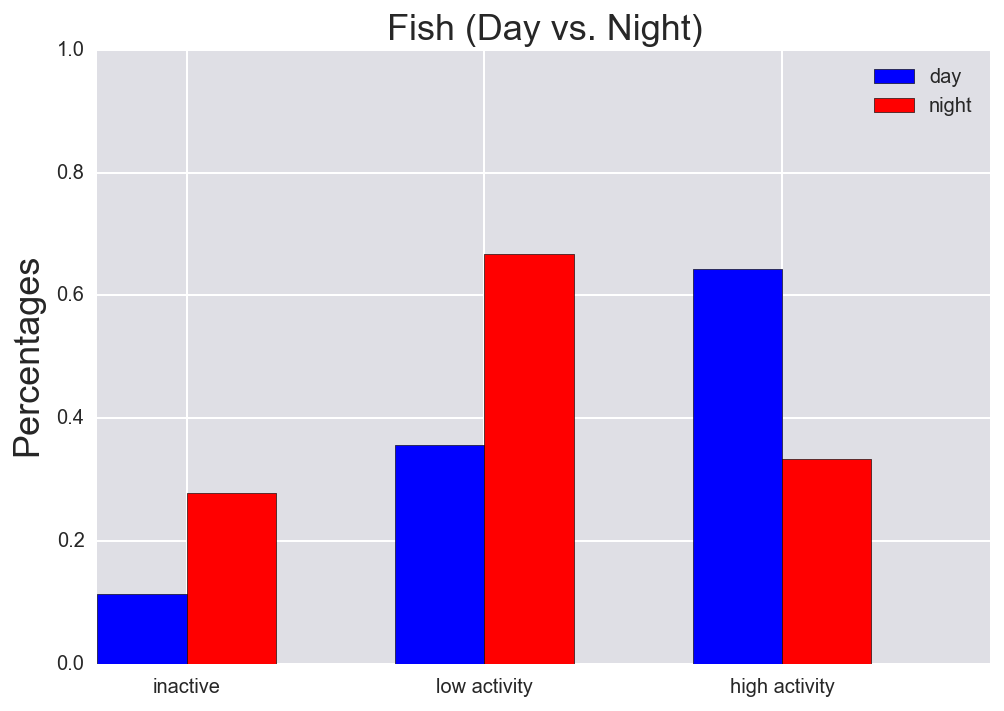

In [71]:
# To find the percentage of time spent in each state we divide the number of intervals
# spent in each state by the total number of intervals during the night
inactive_per_day = inactive_day['activity'].count()/df_day['activity'].count()
low_activity_per_day = low_activity_day['activity'].count()/df_day['activity'].count()
high_activity_per_day = high_activity_day['activity'].count()/df_day['activity'].count()

inactive_per_night = inactive_night['activity'].count()/df_night['activity'].count()
low_activity_per_night = low_activity_night['activity'].count()/df_night['activity'].count()
high_activity_per_night = high_activity_night['activity'].count()/df_night['activity'].count()

# Plot our data
fish1 = [inactive_per_day, low_activity_per_day, high_activity_per_day]
fish1 = [inactive_per_night, low_activity_per_night, high_activity_per_night]
fig = plt.figure()
ax = plt.subplot(111)
x = np.arange(3)
day = ax.bar(x, fish1_day, width = 0.30, color='blue')
night = ax.bar(x + 0.3, fish1_night, width = 0.30, color='red')

ax.set_ylim(0,1)
ax.set_ylabel('Percentages')
ax.set_xticks(x+0.3)
ax.set_xticklabels(['inactive', 'low activity', 'high activity'])
plt.title ('Fish (Day vs. Night)')
plt.legend(('day', 'night'), loc='upper right')

With this comparison of day vs. night, we can use our parameter of percent time spent in each activity state to determine when the fish are more likely to be sleeping. We can see clearly that at night the fish spend a greater percentage of time in an inactive state and in a low activity state than they do during the day. This lets us infer that the fish tend to sleep at night rather than during the day; in other words, zebrafish are diurnal organisms.  

<u>Strengths and weaknesses of this parameter</u>

In the end, we came to the conclusion that this parameter (percent time spent in different activity states, and in particular the pooled percentages) does not have many strengths as a sleep metric. In fact, the only strength we could think of is that with the bar plots, it is fairly easy to understand at a glance - although it is not necessarily easier to understand than the other two parameters we tried. Much more prominent than the strengths are the weaknesses of this parameter. By categorizing the activity into three discrete states, we lose some of the detail that was contained in the original continuous quantitative data. We also felt that having to display three activity states on the same plot made it difficult to compare the genotypes with beeswarm plots or box plots, which quickly start to look cluttered; this is one reason why we settled for pooling the data and using bar plots, which are usually less than ideal. Another important weakness is that by pooling the data across the fish, we lose information about the variability within genotypes or the presence of any outliers that may skew the results. 

**Overall comparison of our three parameters**

Given the many weaknesses of our third parameter (percent time spent in different activity states), we prefer mean activity during daytime and nighttime as a general parameter of sleep/wakeful behavior. While the mean can be skewed by outliers, we nevertheless found mean activity to be a useful metric that helped us generate more hypotheses about the role of the <i>aanat2</i> gene. We also think that our first parameter, sleep latency, has value as a metric of a specific aspect of sleep behavior that is relevant to the definition of insomnia. Thus, out of the three parameters we tested, we prefer a combination of our first (sleep latency) and second (mean activity).     